In [1]:
import os.path as os

import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.datasets import ModelNet
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MLP, Linear, PointNetConv, fps, global_max_pool, radius
from torch_geometric.typing import WITH_TORCH_CLUSTER

if not WITH_TORCH_CLUSTER:
    quit("This example requires 'torch-cluster'")
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# data set imports
import dataset_utils as du
from torch.utils.data import DataLoader, random_split

B = 10

# load dataset
dataset = du.SDFDataset("./cars995")
train_percent = 0.9755


# split dataset into training and validation sets
train_size = int(train_percent * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=B, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train dataset size: {len(train_dataset)}, Validation dataset size: {len(val_dataset)}")

Train dataset size: 970, Validation dataset size: 25


In [3]:
def process_batch(batch, np_in=2048, np_q=15000):
    B, N, _ = batch.shape
    coords = batch[..., :3]   # [B, N, 3]
    sdfs   = batch[...,  3]   # [B, N]

    idx_in = torch.stack([
        torch.randperm(N, device=batch.device)[:np_in]
        for _ in range(B)
    ], dim=0)               # [B, np_in] # random samples

    idx_q  = torch.stack([
        torch.randperm(N, device=batch.device)[:np_q]
        for _ in range(B)
    ], dim=0)               # [B, np_q] # random samples

    batch_ids = torch.arange(B, device=batch.device).unsqueeze(1)
    pos = coords[batch_ids, idx_in]       # [B, np_in,  3]
    x = sdfs[batch_ids, idx_in].unsqueeze(-1)  # [B, np_in, 1]

    query_pos = coords[batch_ids, idx_q]        # [B, np_q,  3]
    query_sdf = sdfs[batch_ids, idx_q].unsqueeze(-1)          # [B, np_q, 1]

    pos = pos.reshape(-1, 3).contiguous()      # [B*np_in, 3]
    x = x.reshape(-1, 1).contiguous()        # [B*np_in, 1]
    batch_idx = batch_ids.repeat(1, np_in)           # [B, np_in]
    batch_idx = batch_idx.reshape(-1).contiguous()   # [B*np_in]
    
    return x.to(device), pos.to(device), batch_idx.to(device), query_pos.to(device), query_sdf.to(device)

Define Layers and Model

In [10]:
class SAModule(torch.nn.Module):
    def __init__(self, ratio, r, nn):
        super().__init__()
        self.ratio = ratio
        self.r = r
        self.conv = PointNetConv(nn, add_self_loops=False)

    def forward(self, x, pos, batch):
        idx = fps(pos, batch, ratio=self.ratio)
        row, col = radius(pos, pos[idx], self.r, batch, batch[idx],
                          max_num_neighbors=128)
        edge_index = torch.stack([col, row], dim=0)
        x_dst = None if x is None else x[idx]
        x = self.conv((x, x_dst), (pos, pos[idx]), edge_index)
        pos, batch = pos[idx], batch[idx]
        return x, pos, batch


class GlobalSAModule(torch.nn.Module):
    def __init__(self, nn):
        super().__init__()
        self.nn = nn

    def forward(self, x, pos, batch):
        x = self.nn(torch.cat([x, pos], dim=1))
        x = global_max_pool(x, batch)
        pos = pos.new_zeros((x.size(0), 3))
        batch = torch.arange(x.size(0), device=batch.device)
        return x, pos, batch


class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Input channels account for both `pos` and node features.
        self.sa1_module = SAModule(0.5, 0.2, MLP([4, 64, 64, 128]))
        self.sa2_module = SAModule(0.25, 0.5, MLP([128 + 3, 128, 128, 256]))
        self.sa3_module = GlobalSAModule(MLP([256 + 3, 256, 512, 1024]))

        self.encode = MLP([1024, 512], dropout=0.4, norm=None) # learn global features -> reduce to 512

        self.mlp_mu = MLP([512, 512], dropout=0.2, norm=None) # get mu
        self.mlp_logvar = MLP([512, 512], dropout=0.2, norm=None) # get logvar

        self.sdf1 = MLP([512 + 3, 256, 128], norm=None)
        self.sdf2 = MLP([128 + 3, 64, 1], norm=None)
        
    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std) # std just gives dimension of tensor to give back
        return mu + epsilon * std


    def encoder(self, x, pos, batch):
        # encode shape
        sa0_out = (x, pos, batch)
        sa1_out = self.sa1_module(*sa0_out)
        sa2_out = self.sa2_module(*sa1_out)
        sa3_out = self.sa3_module(*sa2_out)
        return sa3_out # x latent encoding from pointnet


    def vae(self, x):
        x = self.encode(x)
        mu = self.mlp_mu(x) # [1, 512]
        logvar = self.mlp_logvar(x) # [1, 512]
        z = self.reparametrize(mu, logvar) # [1, 512]
        return z, mu, logvar


    def decoder(self, x, query_pos):
        B = query_pos.shape[0] # get batch_size

        x = torch.cat((x.reshape(B, -1, 512).repeat(1, query_pos.shape[1], 1), query_pos), dim=-1) # concatenate encoded shape with query positions) # [B, np_q, 515]
        x = self.sdf1(x) # [B, np_q, 128]
        x = torch.cat((x, query_pos), dim=-1) # [B, np_q, 131]
        x = self.sdf2(x) # [B, np_q, 1]
        out = torch.tanh(x) # [B, np_q, 1]

        return out


    def forward(self, x, pos, batch, query_pos):
        # encode
        x, pos, batch = self.encoder(x, pos, batch)

        # vae
        x, mu, logvar = self.vae(x)
       
        # decoder
        out = self.decoder(x, query_pos)

        return out, mu, logvar

Define Loss

In [13]:
def eikonal_loss(out, query_pos):
    grads = torch.autograd.grad(out.sum(), query_pos, create_graph=True)[0]
    loss = ((grads.norm(2, dim=1) - 1).square()).mean()
    return loss

def compute_loss(out, query_pos, query_sdf, mu, logvar, w_eik=0.001, w_kl=0.001):
    loss_mse = F.mse_loss(out, query_sdf)
    loss_eik = eikonal_loss(out, query_pos)
    loss_kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # KL Divergence loss for latent distribution

    total_loss = loss_mse + w_eik * loss_eik + w_kl * loss_kl
    #print(f'MSE Loss: {loss_mse:.4f}, Eikonal Loss: {w_eik*loss_eik:.4f}, KL Loss: {w_kl*loss_kl:.4f}') 
    
    return total_loss

In [14]:
# test model
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch = next(iter(train_loader))
print(f'Batch shape: {batch.shape}')
x, pos, batch, query_pos, query_sdf = process_batch(batch)
query_pos.requires_grad = True
print(f'pos shape: {pos.shape}, query_pos shape: {query_pos.shape}, query_sdf shape: {query_sdf.shape}, x shape: {x.shape}')

print(f'pos shape: {pos.shape}')
# forward pass
output, mu, logvar = model(x, pos, batch, query_pos)
# print output shape
print(f"Output shape: {output.shape}")

loss = compute_loss(output, query_pos, query_sdf, mu, logvar)
print(f'Loss: {loss.item()}')

Batch shape: torch.Size([10, 30000, 4])
pos shape: torch.Size([20480, 3]), query_pos shape: torch.Size([10, 15000, 3]), query_sdf shape: torch.Size([10, 15000, 1]), x shape: torch.Size([20480, 1])
pos shape: torch.Size([20480, 3])
Output shape: torch.Size([10, 15000, 1])
Loss: 0.39529910683631897


MODEL


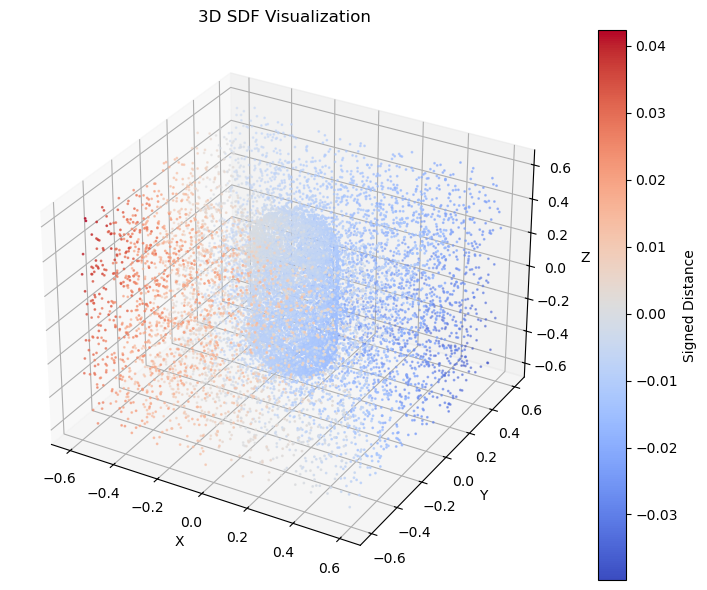

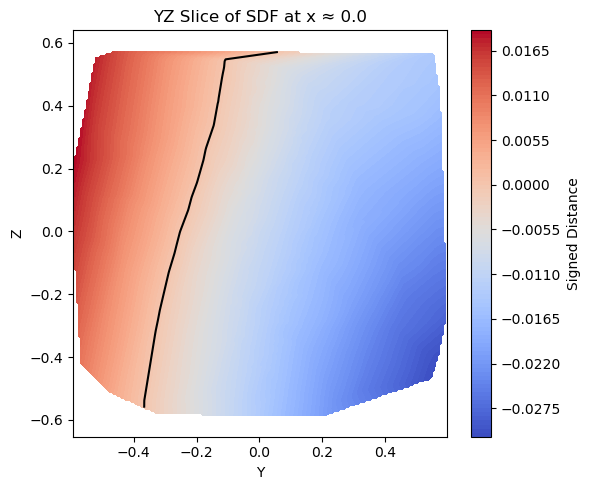

TRUTH


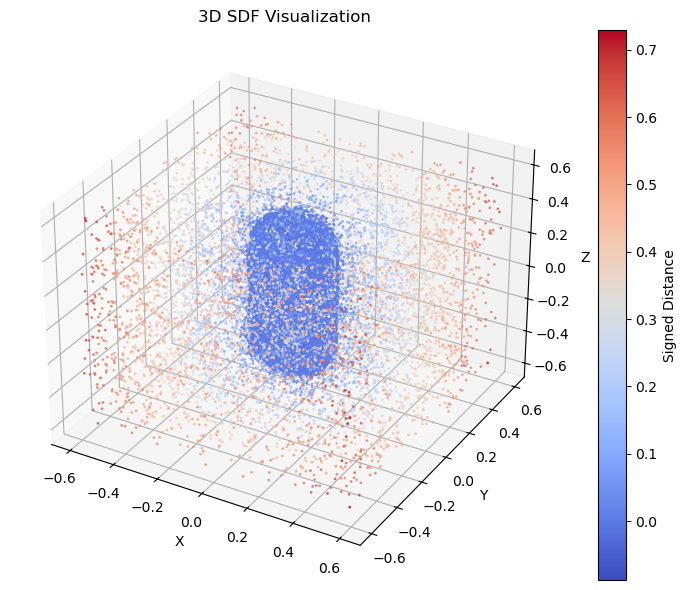

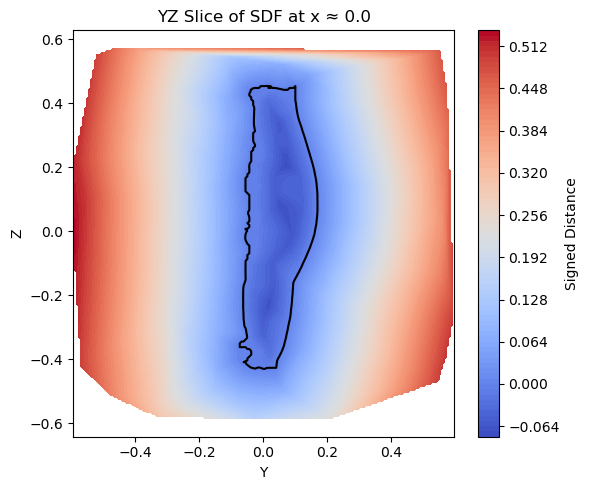

Validation Loss: 0.0737


tensor(0.0737, grad_fn=<AddBackward0>)

In [15]:
def show_validation():
    model.eval()
    batch = next(iter(val_loader))
    batch = batch[0,:,:].unsqueeze(0) # just take first pointcloud from batch
    
    x, pos, batch, query_pos, query_sdf = process_batch(batch)
    query_pos.requires_grad = True
    
    output, mu, logvar = model(x, pos, batch, query_pos)

    prediction = torch.cat((query_pos, output), dim=-1).detach().cpu()  # (1024, 3 + 1)
    truth = torch.cat((query_pos, query_sdf), dim=-1).detach().cpu()  # (1024, 3 + 1)
    

    print("MODEL")
    du.visualize_sdf_3d(prediction.squeeze(0))
    du.visualize_sdf_2d(prediction.squeeze(0))
    print("TRUTH")
    du.visualize_sdf_3d(truth.squeeze(0))
    du.visualize_sdf_2d(truth.squeeze(0))

    loss = compute_loss(output, query_pos, query_sdf, mu, logvar)  # L1 loss for SDF prediction
    print("Validation Loss: {:.4f}".format(loss.item()))

    return loss

show_validation()

In [16]:
from tqdm import tqdm

EPOCHS = 60

def train(epoch):
    model.train()
    for batch in train_loader:
        x, pos, batch, query_pos, query_sdf = process_batch(batch)
        query_pos.requires_grad = True
        optimizer.zero_grad()
        out, mu, logvar = model(x, pos, batch, query_pos)
        loss = compute_loss(out, query_pos, query_sdf, mu, logvar)
        loss.backward()
        optimizer.step()
    
    return loss.item()


log_path = 'loss_log.txt'
with open(log_path, 'w') as f:
    f.write('epoch,train_loss\n')

    for epoch in range(1, EPOCHS+1):
        loss = train(epoch)                     

        # write to file
        f.write(f'{epoch},{loss:.4f}\n')
        f.flush()
        
        # 5) (Optional) console feedback every 20 epochs
        if epoch % 20 == 0:
            print(f'Epoch {epoch:4d} | Loss: {loss:.4f}')
        if epoch % 20 == 0:
            show_validation()
            torch.save(model.state_dict(), 'pointnet_vaesdf.pth') # save model


KeyboardInterrupt: 